
# The End-to-End Data Science Workflow — Notebook 3/4 
## Modeling, Evaluation, Thresholding & Interpretation 📈

**Goal.** Train and evaluate models with cross-validation, perform basic hyperparameter search,
tune decision thresholds for business goals, and interpret model behavior responsibly.

**Libraries used (with roles):**
- `scikit-learn`: models (logistic regression, random forest), CV, metrics, plots.
- `matplotlib`: ROC/PR/CM plots, importance bars.
- `joblib`: persist fitted models.
- `numpy`, `pandas`: evaluation tables, simple reporting.


In [1]:

# ====== Imports, Paths, Seed ======
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance

RANDOM_SEED = 42; np.random.seed(RANDOM_SEED)
DATA_DIR = Path("data"); ARTIFACTS_DIR = Path("artifacts")
DATA_DIR.mkdir(exist_ok=True); ARTIFACTS_DIR.mkdir(exist_ok=True)

CLEAN_DATA_PATH = DATA_DIR / "loan_default_clean_base.csv"
FINAL_MODEL_PATH = ARTIFACTS_DIR / "final_model.joblib"
MODEL_CARD_PATH = ARTIFACTS_DIR / "model_card.txt"

plt.rcParams["figure.figsize"] = (7, 4.5)


In [2]:

# ====== Load Data & Rebuild Preprocessor (self-contained) ======
df = pd.read_csv(CLEAN_DATA_PATH, parse_dates=["application_date"])
y = df["default"].astype(int); X = df.drop(columns=["default"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

class FeatureGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, clip_dti=10.0):
        self.clip_dti = clip_dti
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_ = X.copy()
        X_["dti"] = (X_["total_debt"]/np.maximum(X_["income"],1.0)).replace([np.inf,-np.inf], np.nan).clip(0, self.clip_dti)
        X_["app_month"] = X_["application_date"].dt.month
        X_["app_dayofweek"] = X_["application_date"].dt.dayofweek
        X_["app_year"] = X_["application_date"].dt.year
        X_["rate_term_interaction"] = X_["interest_rate"] * X_["term_months"]
        X_["amount_income_ratio"] = X_["loan_amount"] / np.maximum(X_["income"], 1.0)
        return X_

ordinal_edu = ["High School","Bachelor","Master","PhD"]
numeric_features = ["age","income","loan_amount","term_months","interest_rate","credit_score","employment_years","total_debt","dti","app_month","app_dayofweek","app_year","rate_term_interaction","amount_income_ratio"]
categorical_nominal = ["state","home_ownership","purpose","applicant_gender"]
categorical_ordinal = ["education_level"]

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())])
ord_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ord", OrdinalEncoder(categories=[ordinal_edu], dtype=float))])
nom_pipe = Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

pre = ColumnTransformer([("num", num_pipe, numeric_features), ("ord", ord_pipe, categorical_ordinal), ("nom", nom_pipe, categorical_nominal)], remainder="drop")
preprocess = Pipeline([("feat", FeatureGenerator()), ("pre", pre)])

print("Train:", X_train.shape, " Test:", X_test.shape, " Pos rate:", y_train.mean().round(3))


Train: (4800, 15)  Test: (1200, 15)  Pos rate: 0.103


In [3]:

# ====== Baseline: Logistic Regression (CV) ======
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
log_reg = Pipeline([("preprocess", preprocess), ("clf", LogisticRegression(max_iter=400, C=1.0))])
scoring = {"acc":"accuracy","prec":"precision","rec":"recall","f1":"f1","roc":"roc_auc"}
cv_res_log = cross_validate(log_reg, X_train, y_train, cv=cv, scoring=scoring)
print("Logistic Regression CV (mean ± std):")
for k in scoring:
    print(f"  {k:>4}: {cv_res_log['test_'+k].mean():.3f} ± {cv_res_log['test_'+k].std():.3f}")


Logistic Regression CV (mean ± std):
   acc: 0.898 ± 0.001
  prec: 0.617 ± 0.100
   rec: 0.018 ± 0.008
    f1: 0.035 ± 0.014
   roc: 0.613 ± 0.047


In [4]:

# ====== Flexible Model: Random Forest (CV + Randomized Search) ======
rf = Pipeline([("preprocess", preprocess), ("clf", RandomForestClassifier(random_state=RANDOM_SEED))])
param_dist = {
    "clf__n_estimators": [300, 500, 800],
    "clf__max_depth": [None, 8, 12, 18],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", None]
}
search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=18, scoring="roc_auc", cv=cv, random_state=RANDOM_SEED, verbose=0)
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best RF params:", search.best_params_)
print("Best CV ROC AUC:", search.best_score_)


Best RF params: {'clf__n_estimators': 800, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 8}
Best CV ROC AUC: 0.6170743439036122


Default-threshold metrics:
 thr          0.500
accuracy     0.897
precision    0.000
recall       0.000
f1           0.000
roc_auc      0.653
dtype: float64


/home/simon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 432x288 with 0 Axes>

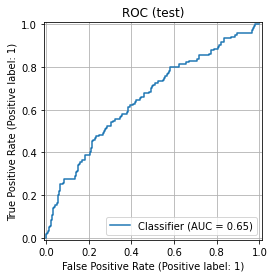

<Figure size 432x288 with 0 Axes>

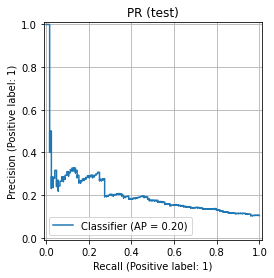

<Figure size 432x288 with 0 Axes>

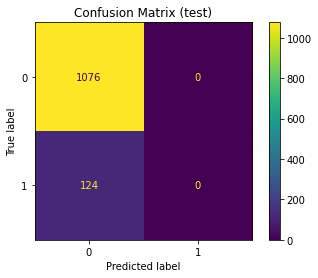

In [5]:

# ====== Test Set Evaluation (default 0.5 threshold) ======
y_proba = best_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

def metrics_table(y_true, y_prob, thr):
    yp = (y_prob >= thr).astype(int)
    return pd.Series({
        "thr": thr,
        "accuracy": accuracy_score(y_true, yp),
        "precision": precision_score(y_true, yp),
        "recall": recall_score(y_true, yp),
        "f1": f1_score(y_true, yp),
        "roc_auc": roc_auc_score(y_true, y_prob)
    })

print("Default-threshold metrics:\n", metrics_table(y_test, y_proba, 0.5).round(3))

# Standard plots
fig = plt.figure(); RocCurveDisplay.from_predictions(y_test, y_proba); plt.title("ROC (test)"); plt.grid(True); plt.show()
fig = plt.figure(); PrecisionRecallDisplay.from_predictions(y_test, y_proba); plt.title("PR (test)"); plt.grid(True); plt.show()
fig = plt.figure(); ConfusionMatrixDisplay.from_predictions(y_test, y_pred); plt.title("Confusion Matrix (test)"); plt.show()


In [6]:

# ====== Threshold Tuning by F1 (illustration) ======
ths = np.linspace(0.1, 0.9, 17)
rows = [metrics_table(y_test, y_proba, t) for t in ths]
mtab = pd.DataFrame(rows).set_index("thr")
display(mtab.round(3).sort_values("f1", ascending=False).head(5))
best_thr = mtab["f1"].idxmax()
print("Best threshold by F1:", best_thr)


/home/simon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/simon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/simon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/simon/.local/lib/python3.10/site-packages/s

,accuracy,precision,recall,f1,roc_auc
thr,,,,,
0.15,0.838,0.245,0.274,0.259,0.653
0.10,0.622,0.152,0.581,0.241,0.653
0.20,0.876,0.295,0.145,0.195,0.653
0.25,0.885,0.250,0.056,0.092,0.653
0.30,0.893,0.300,0.024,0.045,0.653


Best threshold by F1: 0.15000000000000002


In [7]:

# ====== Fairness sanity check (group-wise TPR by gender) ======
df_test = X_test.copy()
df_test["default"] = y_test.values
df_test["proba"] = y_proba
df_test["pred_f1opt"] = (y_proba >= best_thr).astype(int)

def tpr_for(df, group_label, thr_col):
    sub = df[df["applicant_gender"] == group_label]
    tp = ((sub["default"] == 1) & (sub[thr_col] == 1)).sum()
    fn = ((sub["default"] == 1) & (sub[thr_col] == 0)).sum()
    return tp / max(tp + fn, 1)

for g in ["F","M"]:
    print(f"TPR (gender={g}) at F1-opt threshold: {tpr_for(df_test, g, 'pred_f1opt'):.3f}")


TPR (gender=F) at F1-opt threshold: 0.322
TPR (gender=M) at F1-opt threshold: 0.231


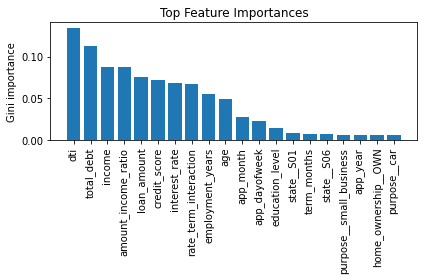

In [ ]:
# ====== Interpretation: Feature Importances & Permutation Importance ======
# We compute two views consistently in transformed feature space:
# (1) Random Forest Gini importances on transformed features.
# (2) Permutation importance on the RF using the transformed test matrix,
#     so that the importances align with the transformed feature names.

# Compose transformed feature names
pre = best_model.named_steps["preprocess"].named_steps["pre"]
ohe = pre.named_transformers_["nom"].named_steps["ohe"]
ohe_names = []
for col, cats in zip(["state","home_ownership","purpose","applicant_gender"], ohe.categories_):
    for c in cats:
        ohe_names.append(f"{col}__{c}")
feature_names = ["age","income","loan_amount","term_months","interest_rate","credit_score",
                 "employment_years","total_debt","dti","app_month","app_dayofweek",
                 "app_year","rate_term_interaction","amount_income_ratio"] \
                + ["education_level"] + ohe_names

# Transform X_test exactly as in the pipeline
X_test_trans = best_model.named_steps["preprocess"].transform(X_test)

# Gini importances
rf_clf = best_model.named_steps["clf"]
imp = rf_clf.feature_importances_
order = np.argsort(imp)[::-1]

top_k = min(20, len(feature_names))
fig = plt.figure()
plt.bar(range(top_k), imp[order][:top_k])
plt.xticks(range(top_k), [feature_names[i] for i in order[:top_k]], rotation=90)
plt.ylabel("Gini importance"); plt.title("Top Feature Importances"); plt.tight_layout(); plt.show()

# Permutation importance on transformed features (aligns lengths and labels)
perm = permutation_importance(rf_clf, X_test_trans, y_test, n_repeats=5,
                              random_state=RANDOM_SEED, scoring="roc_auc")
porder = np.argsort(perm.importances_mean)[::-1]

fig = plt.figure()
plt.bar(range(top_k), perm.importances_mean[porder][:top_k])
plt.xticks(range(top_k), [feature_names[i] for i in porder[:top_k]], rotation=90)
plt.ylabel("Permutation ΔAUC"); plt.title("Top Permutation Importances")
plt.tight_layout(); plt.show()


In [ ]:

# ====== Persist Final Model & Minimal Model Card ======
joblib.dump(best_model, FINAL_MODEL_PATH)
with open(MODEL_CARD_PATH, "w", encoding="utf-8") as f:
    f.write("MODEL CARD (Summary)\n")
    f.write("- Problem: loan default prediction (synthetic)\n")
    f.write("- Data: 2023–2024 synthetic applications; numeric+categorical features\n")
    f.write("- Preprocessing: FeatureGenerator + ColumnTransformer (median impute, standardize, OHE, ordinal enc.)\n")
    f.write("- Model: RandomForest (RandomizedSearchCV), evaluated via 5-fold CV on train; final metrics on held-out test\n")
    f.write("- Metrics: ROC-AUC primary; also precision, recall, F1; threshold tuned for F1\n")
    f.write("- Fairness sanity: TPR by gender reported\n")
    f.write("- Limits: synthetic data; not for production use\n")
print("Saved final model:", FINAL_MODEL_PATH)
